In [1]:
import json
import math
import random
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd
import torch
import torch.nn as nn

BASE_DIR = Path('.').resolve()
OUT_DIR = BASE_DIR / 'runs'
PROC_META = BASE_DIR / 'proc' / 'processed_metadata.csv'
GLOBAL_STATS_PATH = BASE_DIR / 'proc' / 'global_stats.npz'
VOCAB_PATH = OUT_DIR / 'tokenizer_vocab.json'

INFERENCE_CFG = {
    'seq_len': 64,
    'input_dim': 540,
    'proj_dim': 160,
    'rnn_hidden': 160,
    'rnn_layers': 2,
    'attn_heads': 4,
    'embed_dim': 256,
    'decoder_max_len': 64
}

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {DEVICE}')

Using device: cuda


In [2]:
def load_global_stats(stats_path: Path) -> tuple[np.ndarray, np.ndarray]:
    blob = np.load(stats_path)
    return blob['feature_mean'].astype(np.float32), blob['feature_std'].astype(np.float32)

def normalize_with_stats(seq: np.ndarray, mean_vec: np.ndarray, std_vec: np.ndarray) -> np.ndarray:
    return (seq - mean_vec) / (std_vec + 1e-6)

def center_time_crop(seq: np.ndarray, target_len: int) -> np.ndarray:
    total = seq.shape[0]
    if total <= target_len:
        return seq
    start = (total - target_len) // 2
    return seq[start:start + target_len]

def pad_to_length(seq: np.ndarray, target_len: int) -> np.ndarray:
    if seq.shape[0] >= target_len:
        return seq[:target_len]
    pad = np.zeros((target_len - seq.shape[0], seq.shape[1]), dtype=np.float32)
    return np.vstack([seq, pad])

GLOBAL_MEAN, GLOBAL_STD = load_global_stats(GLOBAL_STATS_PATH)
print('Loaded global stats:', GLOBAL_MEAN.shape)

Loaded global stats: (540,)


In [3]:
class SimpleTokenizer:
    def __init__(self, vocab_path: Path):
        with open(vocab_path, 'r') as fp:
            data = json.load(fp)
        token2id = data['token2id']
        self.token2id = token2id
        self.id2token = {int(v): k for k, v in token2id.items()}
        self.vocab_size = len(self.token2id)
        self.pad_token_id = self.token2id['<pad>']
        self.sos_token_id = self.token2id['<sos>']
        self.eos_token_id = self.token2id['<eos>']

    def encode(self, text: str, add_special_tokens: bool = True) -> list[int]:
        tokens = text.lower().replace(',', '').replace('.', '').split()
        ids = [self.token2id.get(tok, self.token2id['<unk>']) for tok in tokens]
        if add_special_tokens:
            ids = [self.sos_token_id] + ids + [self.eos_token_id]
        return ids

    def decode(self, ids: list[int], skip_special_tokens: bool = True) -> str:
        words = []
        for idx in ids:
            token = self.id2token.get(int(idx), '<unk>')
            if skip_special_tokens and token in {'<pad>', '<sos>', '<eos>'}:
                continue
            words.append(token)
        return ' '.join(words)

tokenizer = SimpleTokenizer(VOCAB_PATH)
print('Tokenizer loaded:', tokenizer.vocab_size, 'tokens')

Tokenizer loaded: 4249 tokens


In [4]:
class FrameProjector(nn.Module):
    def __init__(self, in_dim, proj_dim=160):
        super().__init__()
        self.norm = nn.LayerNorm(in_dim)
        self.fc1 = nn.Linear(in_dim, proj_dim)
        self.fc2 = nn.Linear(proj_dim, proj_dim)
        self.act = nn.GELU()
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        out = self.norm(x)
        out = self.act(self.fc1(out))
        out = self.dropout(out)
        out = self.act(self.fc2(out))
        return out


class TemporalEncoder(nn.Module):
    def __init__(self, in_dim, hidden=160, n_layers=2, embed_dim=256, attn_heads=4):
        super().__init__()
        self.gru = nn.GRU(
            in_dim,
            hidden,
            num_layers=n_layers,
            batch_first=True,
            bidirectional=True,
            dropout=0.1 if n_layers > 1 else 0.0
        )
        self.attn_heads = attn_heads
        self.attn_key = nn.Linear(hidden * 2, hidden)
        self.attn_score = nn.Linear(hidden, attn_heads)
        self.attn_proj = nn.Linear(hidden * 2, embed_dim)
        self.context_proj = nn.Linear(hidden * 2, embed_dim)
        self.post_norm = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x, return_sequence=False):
        seq_out, _ = self.gru(x)
        keys = torch.tanh(self.attn_key(seq_out))
        attn_logits = self.attn_score(keys)

        motion = torch.norm(x[:, 1:] - x[:, :-1], dim=-1, keepdim=True)
        motion = torch.cat([motion[:, :1], motion], dim=1)
        motion = (motion - motion.mean(dim=1, keepdim=True)) / (motion.std(dim=1, keepdim=True) + 1e-6)
        attn_logits = attn_logits + motion

        weights = torch.softmax(attn_logits, dim=1)
        pooled = torch.sum(seq_out.unsqueeze(-2) * weights.unsqueeze(-1), dim=1)
        pooled = pooled.mean(dim=1)

        embedding = self.attn_proj(self.dropout(pooled))
        embedding = self.post_norm(embedding)
        embedding = nn.functional.normalize(embedding, dim=-1)

        if return_sequence:
            context = self.context_proj(seq_out)
            return embedding, weights.mean(dim=2), context
        return embedding, weights.mean(dim=2)


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[: x.size(0), :]
        return self.dropout(x)


class SignTranslationModel(nn.Module):
    def __init__(self, input_dim, vocab_size, proj_dim=160, hidden=160, n_layers=2, embed_dim=256, attn_heads=4):
        super().__init__()
        self.projector = FrameProjector(input_dim, proj_dim)
        self.encoder = TemporalEncoder(proj_dim, hidden, n_layers, embed_dim, attn_heads)
        self.tgt_embed = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoder = PositionalEncoding(embed_dim)
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=embed_dim, nhead=attn_heads, dim_feedforward=embed_dim * 4, dropout=0.1
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=2)
        self.generator = nn.Linear(embed_dim, vocab_size)
        self.embed_dim = embed_dim

    def forward(self, src, tgt, tgt_mask=None, tgt_pad_mask=None):
        proj = self.projector(src)
        embedding, attn_weights, context = self.encoder(proj, return_sequence=True)
        memory = context.permute(1, 0, 2)

        tgt_emb = self.tgt_embed(tgt).permute(1, 0, 2)
        tgt_emb = self.pos_encoder(tgt_emb)

        output = self.decoder(
            tgt_emb,
            memory,
            tgt_mask=tgt_mask,
            tgt_key_padding_mask=tgt_pad_mask
        )
        logits = self.generator(output.permute(1, 0, 2))
        return logits, embedding

    def encode_for_inference(self, x):
        proj = self.projector(x)
        embedding, attn_weights, context = self.encoder(proj, return_sequence=True)
        return embedding, proj, attn_weights

In [17]:
from collections import Counter

def generate_square_subsequent_mask(sz: int) -> torch.Tensor:
    mask = torch.triu(torch.ones(sz, sz)) == 1
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

@torch.no_grad()
def greedy_decode_batch(model, src_batch, tokenizer, max_len=64):
    model.eval()
    device = src_batch.device
    proj = model.projector(src_batch)
    _, _, context = model.encoder(proj, return_sequence=True)
    memory = context.permute(1, 0, 2)

    ys = torch.full((src_batch.size(0), 1), tokenizer.sos_token_id, dtype=torch.long, device=device)
    finished = torch.zeros(src_batch.size(0), dtype=torch.bool, device=device)

    for _ in range(max_len):
        tgt_emb = model.tgt_embed(ys).permute(1, 0, 2)
        tgt_emb = model.pos_encoder(tgt_emb)
        tgt_mask = generate_square_subsequent_mask(ys.size(1)).to(device)
        tgt_pad_mask = torch.zeros((ys.size(0), ys.size(1)), dtype=torch.bool, device=device)
        out = model.decoder(tgt_emb, memory, tgt_mask=tgt_mask, tgt_key_padding_mask=tgt_pad_mask)
        logits = model.generator(out.permute(1, 0, 2))
        next_token = logits[:, -1, :].argmax(dim=-1)
        ys = torch.cat([ys, next_token.unsqueeze(1)], dim=1)
        finished |= next_token == tokenizer.eos_token_id
        if finished.all():
            break

    return ys[:, 1:]

def ids_to_sentence(token_ids, tokenizer):
    if isinstance(token_ids, torch.Tensor):
        ids = token_ids.tolist()
    else:
        ids = list(token_ids)
    cleaned = []
    for tid in ids:
        if tid == tokenizer.eos_token_id:
            break
        if tid == tokenizer.pad_token_id:
            continue
        cleaned.append(tid)
    return tokenizer.decode(cleaned, skip_special_tokens=True).strip()

def word_error_rate(reference: str, hypothesis: str) -> float:
    ref_words = reference.strip().split()
    hyp_words = hypothesis.strip().split()
    if not ref_words and not hyp_words:
        return 0.0
    if not ref_words:
        return float(len(hyp_words) > 0)
    dp = np.zeros((len(ref_words) + 1, len(hyp_words) + 1), dtype=np.int32)
    for i in range(len(ref_words) + 1):
        dp[i, 0] = i
    for j in range(len(hyp_words) + 1):
        dp[0, j] = j
    for i in range(1, len(ref_words) + 1):
        for j in range(1, len(hyp_words) + 1):
            cost = 0 if ref_words[i - 1] == hyp_words[j - 1] else 1
            dp[i, j] = min(
                dp[i - 1, j] + 1,
                dp[i, j - 1] + 1,
                dp[i - 1, j - 1] + cost
            )
    return dp[len(ref_words), len(hyp_words)] / max(len(ref_words), 1)

def simple_bleu_score(reference: str, hypothesis: str, max_n: int = 4) -> float:
    ref_tokens = reference.strip().split()
    hyp_tokens = hypothesis.strip().split()
    if not ref_tokens and not hyp_tokens:
        return 1.0
    if not hyp_tokens:
        return 0.0
    precisions = []
    eps = 1e-9
    for n in range(1, max_n + 1):
        if len(hyp_tokens) < n:
            precisions.append(eps)
            continue
        ref_range = max(len(ref_tokens) - n + 1, 0)
        ref_counts = Counter(tuple(ref_tokens[i:i + n]) for i in range(ref_range))
        hyp_counts = Counter(tuple(hyp_tokens[i:i + n]) for i in range(len(hyp_tokens) - n + 1))
        overlap = sum(min(count, ref_counts.get(gram, 0)) for gram, count in hyp_counts.items())
        total = sum(hyp_counts.values())
        precisions.append((overlap + eps) / (total + eps))
    log_precision = sum(math.log(p) for p in precisions) / len(precisions)
    ref_len = len(ref_tokens)
    hyp_len = len(hyp_tokens)
    bp = 1.0 if hyp_len > ref_len else math.exp(1 - (ref_len / max(hyp_len, 1)))
    return float(bp * math.exp(log_precision))

In [6]:
def load_seq2seq_model(checkpoint_path: Path | None = None) -> SignTranslationModel:
    ckpt_path = Path(checkpoint_path) if checkpoint_path else None
    if ckpt_path is None:
        candidates = sorted(OUT_DIR.glob('best_model_top1_*.pt'))
        if not candidates:
            raise FileNotFoundError('No checkpoint found in runs/.')
        ckpt_path = candidates[-1]
    model = SignTranslationModel(
        input_dim=INFERENCE_CFG['input_dim'],
        vocab_size=tokenizer.vocab_size,
        proj_dim=INFERENCE_CFG['proj_dim'],
        hidden=INFERENCE_CFG['rnn_hidden'],
        n_layers=INFERENCE_CFG['rnn_layers'],
        embed_dim=INFERENCE_CFG['embed_dim'],
        attn_heads=INFERENCE_CFG['attn_heads']
    ).to(DEVICE)
    state_dict = torch.load(ckpt_path, map_location=DEVICE)
    model.load_state_dict(state_dict)
    model.eval()
    print(f'Loaded checkpoint: {ckpt_path}')
    return model

seq2seq_model = load_seq2seq_model()

Loaded checkpoint: /home/zahemen/projects/dl-lib/gsl-tests/runs/best_model_top1_0.898.pt


In [7]:
def load_feature_sequence(path: str | Path) -> np.ndarray:
    arr = np.load(path).astype(np.float32)
    if arr.ndim != 2 or arr.shape[1] != INFERENCE_CFG['input_dim']:
        raise ValueError(f'Unexpected feature shape: {arr.shape}')
    return arr

def preprocess_feature(path: str | Path) -> np.ndarray:
    seq = load_feature_sequence(path)
    if seq.shape[0] > INFERENCE_CFG['seq_len']:
        seq = center_time_crop(seq, INFERENCE_CFG['seq_len'])
    seq = normalize_with_stats(seq, GLOBAL_MEAN, GLOBAL_STD)
    seq = pad_to_length(seq, INFERENCE_CFG['seq_len'])
    return seq.astype(np.float32)

def run_decoder_inference(model, feature_path: str | Path, reference_text: str | None = None, max_len: int | None = None):
    seq = preprocess_feature(feature_path)
    batch = torch.from_numpy(seq).unsqueeze(0).to(DEVICE)
    decoded = greedy_decode_batch(model, batch, tokenizer, max_len=max_len or INFERENCE_CFG['decoder_max_len'])
    prediction = ids_to_sentence(decoded[0], tokenizer)
    metrics = {}
    if reference_text:
        metrics['wer'] = word_error_rate(reference_text, prediction)
        metrics['bleu'] = simple_bleu_score(reference_text, prediction)
    return {'prediction': prediction, 'metrics': metrics}

In [8]:
if not PROC_META.exists():
    raise FileNotFoundError('Processed metadata not found; run preprocessing first.')
meta = pd.read_csv(PROC_META)
sample_row = None
for _ in range(25):
    candidate = meta.sample(1).iloc[0]
    feat_path = Path(candidate['feature_path'])
    if feat_path.exists():
        sample_row = candidate
        break
if sample_row is None:
    raise FileNotFoundError('Could not find a feature file referenced in metadata.')

reference_sentence = sample_row.get('sentence', '')
result = run_decoder_inference(
    seq2seq_model,
    sample_row['feature_path'],
    reference_text=reference_sentence
)

print('Video:', sample_row.get('video_file', 'n/a'))
print('Reference:', reference_sentence)
print('Prediction:', result['prediction'])
if result['metrics']:
    print(f"WER: {result['metrics']['wer']:.3f}")
    print(f"BLEU: {result['metrics']['bleu']:.3f}")

/home/zahemen/miniconda3/envs/signtalk_env/lib/python3.10/site-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Video: 2341B.mp4
Reference: Have you tested for typhoid if the fever continues?
Prediction: have been diagnosed with a test to avoid too much
WER: 1.111
BLEU: 0.000


/home/zahemen/miniconda3/envs/signtalk_env/lib/python3.10/site-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


### Streaming inference helpers
The next cells build a light-weight streaming buffer and motion gate so we can mimic live pose ingest before dispatching tokens to the decoder.

In [9]:
class RollingFeatureBuffer:
    """Maintain a fixed-length sliding window of pose frames for streaming."""

    def __init__(self, feature_dim: int, max_len: int):
        self.feature_dim = feature_dim
        self.max_len = max_len
        self.frames: list[np.ndarray] = []

    def append(self, frame: np.ndarray) -> np.ndarray:
        if frame.shape[-1] != self.feature_dim:
            raise ValueError(f'Expected feature dim {self.feature_dim}, got {frame.shape[-1]}')
        self.frames.append(frame.astype(np.float32))
        if len(self.frames) > self.max_len:
            self.frames = self.frames[-self.max_len:]
        return self.to_array()

    def to_array(self) -> np.ndarray:
        if not self.frames:
            return np.zeros((self.max_len, self.feature_dim), dtype=np.float32)
        seq = np.stack(self.frames, axis=0)
        if seq.shape[0] < self.max_len:
            pad = np.zeros((self.max_len - seq.shape[0], self.feature_dim), dtype=np.float32)
            seq = np.vstack([pad, seq])
        return seq

    def reset(self):
        self.frames.clear()


class MotionEnergyGate:
    """Simple gate that fires when motion energy exceeds a rolling threshold."""

    def __init__(self, window: int = 8, threshold: float = 0.15):
        self.window = window
        self.threshold = threshold
        self.energy_history: list[float] = []

    def update(self, frame_seq: np.ndarray) -> bool:
        if frame_seq.shape[0] < 2:
            return False
        diffs = np.linalg.norm(frame_seq[1:] - frame_seq[:-1], axis=-1)
        energy = float(np.mean(diffs[-self.window:]))
        self.energy_history.append(energy)
        if len(self.energy_history) > 100:
            self.energy_history = self.energy_history[-100:]
        adaptive_thresh = max(self.threshold, np.mean(self.energy_history[-self.window:]) * 0.8)
        return energy > adaptive_thresh

    def reset(self):
        self.energy_history.clear()

In [10]:
def stream_feature_chunks(feature_path: str | Path, chunk_size: int = 4):
    """Yield small frame batches to mimic packets arriving from a pose detector."""
    seq = load_feature_sequence(feature_path)
    for idx in range(0, seq.shape[0], chunk_size):
        yield seq[idx: idx + chunk_size]


def normalize_stream_chunk(chunk: np.ndarray) -> np.ndarray:
    chunk = normalize_with_stats(chunk, GLOBAL_MEAN, GLOBAL_STD)
    return chunk.astype(np.float32)


def simulate_stream(sample_meta_row: pd.Series, chunk_size: int = 4):
    """Generator that yields (frames, metadata) packets for visualization/inference."""
    feature_path = Path(sample_meta_row['feature_path'])
    for packet in stream_feature_chunks(feature_path, chunk_size=chunk_size):
        yield {
            'frames': normalize_stream_chunk(packet),
            'video': sample_meta_row.get('video_file', 'n/a'),
            'sentence': sample_meta_row.get('sentence', '')
        }

In [11]:
@torch.no_grad()
def run_streaming_inference(
    model: SignTranslationModel,
    stream_packets,
    tokenizer: SimpleTokenizer,
    chunk_hop: int = 4,
    emit_every: int = 4,
    gate_threshold: float = 0.12,
    max_tokens: int | None = None
):
    buffer = RollingFeatureBuffer(feature_dim=INFERENCE_CFG['input_dim'], max_len=INFERENCE_CFG['seq_len'])
    gate = MotionEnergyGate(window=emit_every, threshold=gate_threshold)
    decoded_tokens: list[int] = []
    intermediate_predictions = []

    for step, packet in enumerate(stream_packets):
        frames = packet['frames']
        for i in range(0, len(frames), chunk_hop):
            chunk = frames[i:i + chunk_hop]
            if chunk.size == 0:
                continue
            for frame in chunk:
                seq = buffer.append(frame)
                gate_ready = gate.update(seq[-chunk_hop:])
                should_emit = (step + 1) % emit_every == 0 or gate_ready
                if not should_emit:
                    continue
                prep = pad_to_length(seq, INFERENCE_CFG['seq_len'])
                prep = prep.astype(np.float32)
                batch = torch.from_numpy(prep).unsqueeze(0).to(DEVICE)
                decoded = greedy_decode_batch(
                    model,
                    batch,
                    tokenizer,
                    max_len=max_tokens or INFERENCE_CFG['decoder_max_len']
                )
                sentence = ids_to_sentence(decoded[0], tokenizer)
                intermediate_predictions.append(sentence)
                if sentence:
                    decoded_tokens = tokenizer.encode(sentence, add_special_tokens=False)
                if max_tokens and len(decoded_tokens) >= max_tokens:
                    break
            if max_tokens and len(decoded_tokens) >= max_tokens:
                break
        if max_tokens and len(decoded_tokens) >= max_tokens:
            break

    return {
        'final_transcript': intermediate_predictions[-1] if intermediate_predictions else '',
        'all_hypotheses': intermediate_predictions,
        'gate_history': gate.energy_history
    }

In [12]:
if 'sample_row' not in locals():
    raise RuntimeError('sample_row is missing; run the baseline batch inference cell first.')

stream_packets = simulate_stream(sample_row, chunk_size=4)
stream_result = run_streaming_inference(
    seq2seq_model,
    stream_packets,
    tokenizer,
    chunk_hop=2,
    emit_every=4,
    gate_threshold=0.1,
    max_tokens=INFERENCE_CFG['decoder_max_len']
)

print('Streaming final transcript:', stream_result['final_transcript'])
print('Last few partial hypotheses:')
for idx, hyp in enumerate(stream_result['all_hypotheses'][-5:], start=max(len(stream_result['all_hypotheses']) - 4, 1)):
    print(f'  step {idx}: {hyp}')

Streaming final transcript: do you might be mindful of your
Last few partial hypotheses:
  step 235: have been feeling more than the area
  step 236: have been feeling more than the area
  step 237: do you might be mindful of your needs
  step 238: do you might be mindful of your needs
  step 239: do you might be mindful of your


### Visualizing gate energy
Plot the motion energy history captured by the gate to reason about latency/trigger points.

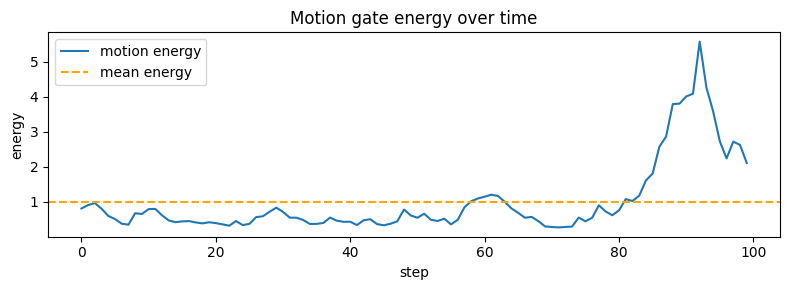

In [13]:
import matplotlib.pyplot as plt

energy = stream_result.get('gate_history', [])
if not energy:
    raise RuntimeError('Gate history empty; run the streaming inference cell first.')
plt.figure(figsize=(8, 3))
plt.plot(energy, label='motion energy')
plt.axhline(y=np.mean(energy), color='orange', linestyle='--', label='mean energy')
plt.title('Motion gate energy over time')
plt.xlabel('step')
plt.ylabel('energy')
plt.legend()
plt.tight_layout()
plt.show()

### Webcam / live capture stub
Below is a helper for testing with OpenCV if MediaPipe and a camera are available. It degrades gracefully when dependencies are missing.

In [14]:
try:
    import cv2  # type: ignore
except Exception as exc:  # pragma: no cover
    cv2 = None
    print('OpenCV not available:', exc)


def capture_webcam_stream(max_frames: int = 256, downsample: int = 2):
    """Yield normalized pose vectors from MediaPipe/OpenCV; returns empty if unavailable."""
    if cv2 is None:
        raise RuntimeError('cv2 is not installed in this environment.')

    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        cap.release()
        raise RuntimeError('Could not open webcam.')

    collected = []
    try:
        frame_idx = 0
        while frame_idx < max_frames:
            ok, frame = cap.read()
            if not ok:
                break
            if frame_idx % downsample == 0:
                # Placeholder: integrate MediaPipe pose extraction here.
                pose_vec = np.zeros(INFERENCE_CFG['input_dim'], dtype=np.float32)
                collected.append(pose_vec)
            frame_idx += 1
    finally:
        cap.release()
    if not collected:
        raise RuntimeError('No frames collected; ensure MediaPipe integration fills pose_vec.')
    seq = np.stack(collected, axis=0)
    seq = normalize_with_stats(seq, GLOBAL_MEAN, GLOBAL_STD)
    return seq

In [15]:
def decode_live_camera(model: SignTranslationModel, tokenizer: SimpleTokenizer):
    if cv2 is None:
        print('cv2 missing; skipping live decode.')
        return
    try:
        seq = capture_webcam_stream()
    except RuntimeError as exc:
        print('Live capture failed:', exc)
        return
    padded = pad_to_length(seq, INFERENCE_CFG['seq_len'])
    batch = torch.from_numpy(padded).unsqueeze(0).to(DEVICE)
    decoded = greedy_decode_batch(model, batch, tokenizer)
    print('Live prediction:', ids_to_sentence(decoded[0], tokenizer))

# decode_live_camera(seq2seq_model, tokenizer)  # Uncomment when pose extraction is wired up

In [16]:
decode_live_camera(seq2seq_model, tokenizer)  # Uncomment when pose extraction is wired up

Live capture failed: Could not open webcam.


[ WARN:0@0.064] global cap_v4l.cpp:914 open VIDEOIO(V4L2:/dev/video0): can't open camera by index
